<a href="https://colab.research.google.com/github/Hussein119/CUDA/blob/master/Compiling_CUDA_with_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compiling CUDA with OpenCV
In this notebook we will show how to compile CUDA C++ code with the OpenCV library, which we will use to load an image and save it back to disk after applying a blur kernel.


## Setup

Install and load the nvcc4jupyter extension, which will allow us to run CUDA C++ code using cell magics. See [the documentation](https://nvcc4jupyter.readthedocs.io/en/latest/usage.html) for details.

In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpfxa6fspt".


## Code

A simple example - multiplying a vector by 10

In [ ]:
%%cuda
#include <stdio.h>
#include <cuda_runtime.h>
const int N = 64;

__global__ void myMul(int* arr_device){
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    arr_device[idx] *= 10;
}

int main(){
    int* arr = (int*)malloc(sizeof(int)*N);
    for(int i = 0; i < N;i++)arr[i] = i;
    int* arr_device;
    cudaMalloc(&arr_device, sizeof(int)*N);
    cudaMemcpy(arr_device, arr, sizeof(int)*N, cudaMemcpyHostToDevice);
    dim3 grid(2,1,1);
    dim3 block(32, 1,1);
    myMul<<<grid,block>>>(arr_device);
    cudaDeviceSynchronize();
    cudaMemcpy(arr, arr_device, sizeof(int)*N, cudaMemcpyDeviceToHost);
    for(int i = 0 ; i < N;i++)printf("%d ", arr[i]);


}

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 


Example 2 : bluring an image

Make sure OpenCV is installed.

In [ ]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Imports

In [ ]:
import os
import subprocess
from IPython.display import Image

### Download an image

Get a random image of IMG_SIZE x IMG_SIZE pixels.

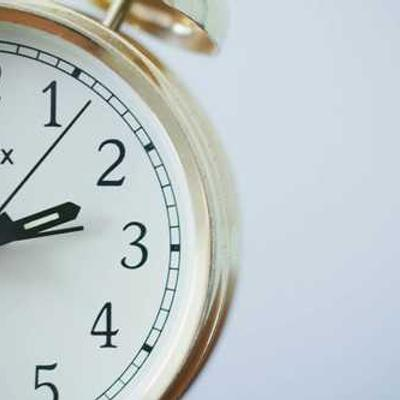

In [ ]:
IMG_SIZE = 400
os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "image.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://picsum.photos/$IMG_SIZE.jpg &> /dev/null
Image(filename=IMG_FNAME)

### Compiler arguments
These are options that you need to pass to the compiler in order to link with the OpenCV library.

In [ ]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


### Blurring the image

In [ ]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <opencv2/core.hpp>
#include <opencv2/imgcodecs.hpp>

#include <iostream>

#define BLUR_SIZE 5
#define R 0
#define G 1
#define B 2

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        cudaError_t __err = cudaGetLastError(); \
        if (__err != cudaSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, cudaGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)

// kernel taken from https://stackoverflow.com/a/65973288
__global__ void blurKernel(
    unsigned char* in,
    unsigned char* out,
    int width,
    int height,
    int num_channel,
    int channel
) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if(col < width && row < height) {
        int pixVal = 0;
        int pixels = 0;
        for(int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE + 1; ++blurRow) {
            for(int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE + 1; ++blurCol) {
                int curRow = row + blurRow;
                int curCol = col + blurCol;
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow * width * num_channel + curCol * num_channel + channel];
                    pixels++;
                }
            }
        }
        out[row * width * num_channel + col * num_channel + channel] = (unsigned char)(pixVal/pixels);
    }
}

int main()
{
    std::string image_path = cv::samples::findFile("image.jpg");
    cv::Mat img = imread(image_path, cv::IMREAD_COLOR);
    if(img.empty())
    {
        std::cerr << "Could not read the image: " << image_path << std::endl;
        return 1;
    }

    // image shape
    int width = img.cols;
    int height = img.rows;
    int n_channels = 3; // hard-coded RGB processing

    // we will read and write directly into the data array of the OpenCV Matrix
    unsigned char *host_image_input = img.data;
    unsigned char *host_image_output = img.data;

    // allocate memory for device arrays
    unsigned char* dev_image_input = NULL;
    unsigned char* dev_image_output = NULL;
    cudaMalloc(
        (void**)&dev_image_input,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaMalloc(
        (void**)&dev_image_output,
        sizeof(unsigned char) * height * width * n_channels
    );
    cudaCheckErrors("cudaMalloc failure");

    // transfer data from host to device for processing on GPU
    cudaMemcpy(
        dev_image_input,
        host_image_input,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyHostToDevice
    );
    cudaCheckErrors("cudaMemcpy H2D failure");

    // run a blur kernel on each channel
    dim3 blockSize(16, 16, 1);
    dim3 gridSize(width/blockSize.x, height/blockSize.y, 1);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, R);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, G);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, B);

    cudaDeviceSynchronize();
    cudaCheckErrors("kernel failure");

    // copy results back to host
    cudaMemcpy(
        host_image_output,
        dev_image_output,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyDeviceToHost
    );
    cudaCheckErrors("cudaMemcpy D2H failure");

    cudaFree(dev_image_input);
    cudaFree(dev_image_output);

    // save the blurred image to disk
    cv::imwrite("image_blurred.jpg", img);
    return 0;
}

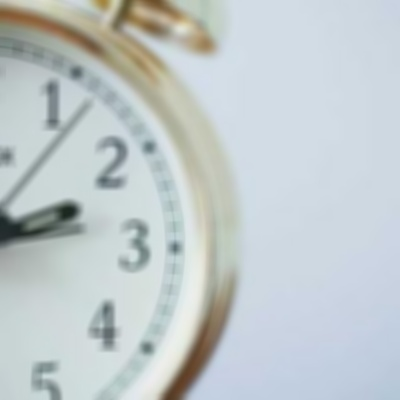

In [ ]:
Image(filename="image_blurred.jpg")